# Statistical study of the labeling for task 1

## Required imports

In [ ]:
# General purpose imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import json
import string
import os
from pathlib import Path

# NLP and ML imports
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.special import rel_entr
from tqdm import tqdm

## Load the data for task1

In [2]:
def remove_emojis(keyword):
    return re.sub(r"[^\w\s,!?@#áéíóúÁÉÍÓÚñÑ]", "", keyword)

def clear_tokens(tokens_list: list) -> None:
    """ Removes punctuation symbols from the given tokens list """
    # Traverse the list backwards to avoid logic problems with pop() and indexes order
    for i in range(len(tokens_list) - 1, -1, -1):
        if tokens_list[i] in string.punctuation:
            tokens_list.pop(i)
    return

def tokenize_and_vectorize(data_path: str, 
                           treat_emojis: bool=False,
                           verbose: bool=False,
                           trained_vectorizer=False) -> tuple:
    """ Tokenizes the messages from all the users and computes vectors from them """
    path            = Path(data_path)
    all_users_data  = []
    tokenizer       = TweetTokenizer()
    vectorizer      = TfidfVectorizer()
    users_order     = [] # List that stores the users in the order that are processed, for merging with the target

    # Iterate through the JSON data folder
    for element in path.iterdir():
        if element.is_file():
            user_id = re.findall(pattern=r"[0-9]+", string=element.name)[0]
            users_order.append(user_id)

            # Some execution verbose
            if verbose:
                print(f"Tokenizing messages from user: {user_id}")

            # Open and read the current JSON file
            with open(data_path + f'/{element.name}') as json_file:
                json_data = json.load(fp=json_file)

                if treat_emojis:
                    # Emojis must be deleted from the messages
                    # messages = [ clean_pipeline(str(record['message'])) for record in json_data ]
                    messages = [ remove_emojis(str(record['message'])) for record in json_data ]

                else:
                    # Preserve emojis in the messages
                    messages = [ str(record['message']) for record in json_data ]

                # Apply the TweetTokenizer algorithm
                tokenized = [ tokenizer.tokenize(m) for m in messages ]

                # Remove punctuation symbols tokens
                for i, t in enumerate(tokenized):
                    clear_tokens(tokens_list=t)

                    # If the resulting list is empty, then remove it
                    if len(t) == 0:
                        tokenized.pop(i)
                
                # Join the tokens of a single message, since that is what expects the implementation of TF-IDF
                user_document = " ".join(tokenized[0])
                for i in range(1, len(tokenized)):
                    tokens_joined = " ".join(tokenized[i])
                    user_document += " " + tokens_joined
            
                # Merge the previous data with the current user's
                all_users_data.append(user_document)

    # Vectorize all the messages with the TF-IDF and return the data as a Pandas DataFrame
    if trained_vectorizer:
        X = trained_vectorizer.transform(all_users_data)
        df = pd.DataFrame(X.toarray(), columns=trained_vectorizer.get_feature_names_out())
    else:
        X  = vectorizer.fit_transform(all_users_data)
        df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    if verbose:
        print("computing sentiment feature")
    # sentiment_scores = [analyze_sentiment(text) for text in all_users_data]
    # df['sentiment'] = sentiment_scores
    
    return df, users_order, vectorizer

In [3]:
# Get the data from all users
data_path_task1                        = os.getcwd() + '/data/task1/complete/subjects/'

# Build the vectorized datasets
df_vectorized_task1, users_order_task1, vectorizer_task1 = tokenize_and_vectorize(data_path=data_path_task1, treat_emojis=True, verbose=False)

In [4]:
# Get the data from the target variable
target_path_task1 = os.getcwd() + '/data/task1/complete/gold_task1.txt'

target_col_task1  = pd.read_csv(filepath_or_buffer=target_path_task1, delimiter=',').to_numpy()
users_tags_task1  = { re.findall(r"[0-9]+", target_col_task1[i][0])[0]: target_col_task1[i][1] for i in range(len(target_col_task1)) }

# Create a copy of the dataset
df_supervised_task1 = df_vectorized_task1.copy()

# Create the target column in order and add it to the Pandas DataFrame
target_task1 = np.array([ users_tags_task1[user_id] for user_id in users_order_task1 ], np.int8)
df_supervised_task1.insert(loc=len(df_supervised_task1.columns), column='Target', value=target_task1)

# Show the first five rows of each Pandas DataFrame
df_supervised_task1.head()

,00,000,0000,0000000,00000000000,00000085,00000110,0000014,0000017,000003,...,últimas,último,últimos,ún,única,únicamente,único,únicos,útiles,Target
0,0.031401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## Test three ML models and analyze the ROC-AUC curve

### k-NN

Accuracy: 0.5138888888888888
Classification report:
               precision    recall  f1-score   support

           0       0.51      1.00      0.68        37
           1       0.00      0.00      0.00        35

    accuracy                           0.51        72
   macro avg       0.26      0.50      0.34        72
weighted avg       0.26      0.51      0.35        72



c:\Users\SIMBAT\anaconda3\envs\DL\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SIMBAT\anaconda3\envs\DL\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SIMBAT\anaconda3\envs\DL\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


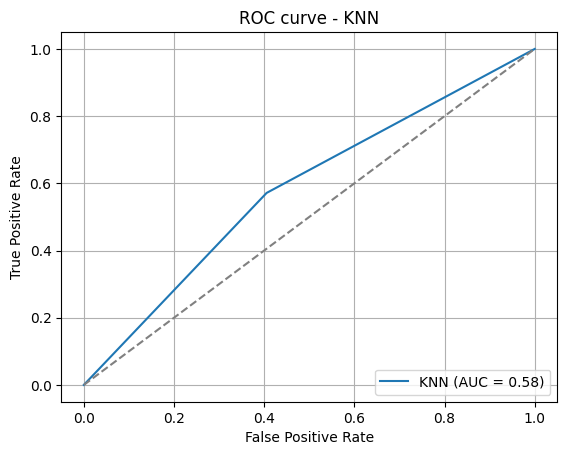

In [5]:
X, y = df_supervised_task1.drop(columns=['Target'], axis=1).to_numpy(), df_supervised_task1['Target'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

plt.figure()
plt.plot(fpr, tpr, label=f'KNN (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - KNN')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Logistic Regression

Accuracy: 0.7083333333333334
Classification report:
               precision    recall  f1-score   support

           0       0.71      0.73      0.72        37
           1       0.71      0.69      0.70        35

    accuracy                           0.71        72
   macro avg       0.71      0.71      0.71        72
weighted avg       0.71      0.71      0.71        72



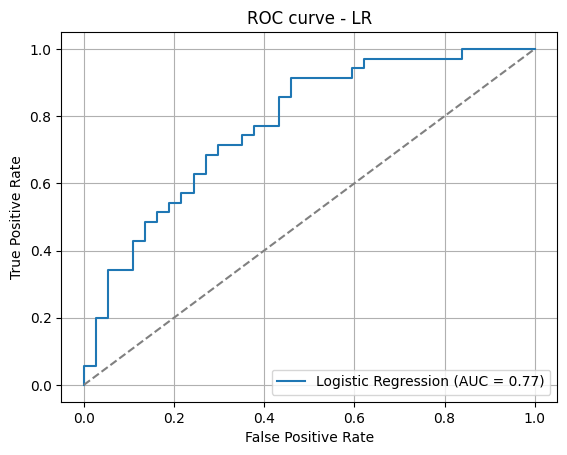

In [6]:
X, y = df_supervised_task1.drop(columns=['Target'], axis=1).to_numpy(), df_supervised_task1['Target'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = LogisticRegression(C=2)
lr.fit(X_train, y_train)

y_pred  = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

plt.figure()
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - LR')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Decision Tree (ID3)

Accuracy: 0.5833333333333334
Classification report:
               precision    recall  f1-score   support

           0       0.53      0.58      0.55        48
           1       0.64      0.58      0.61        60

    accuracy                           0.58       108
   macro avg       0.58      0.58      0.58       108
weighted avg       0.59      0.58      0.58       108



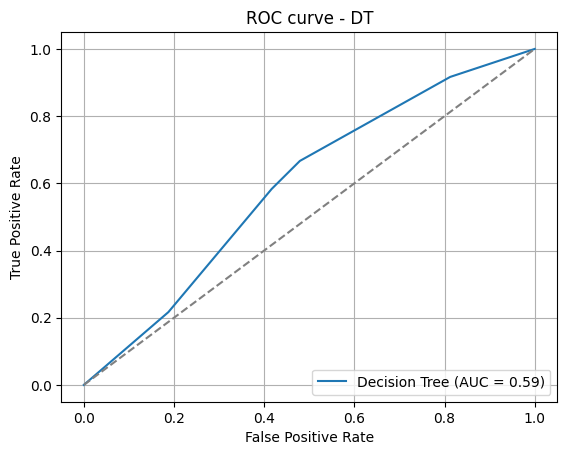

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=420)

tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_proba = tree.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

plt.figure()
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - DT')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Clusterize users by using the k-means algorithm

The idea is to perform multiple executions of the k-means algorithm in order to identify vectors (representing users) that are similar to one another. By determining the optimal value of k (the number of clusters) and conducting a descriptive analysis to characterize the different groups, it becomes possible to assess whether the data may have been labeled in a random manner.

The original class proportions are 50% for each label (Low-risk and High-risk), meaning that a random selection to generate a sample from the entire dataset should preserve these proportions in a stratified manner. However, when selecting data based on the clusters returned by k-means, the selection is biased—since it is not random, those proportions are not necessarily maintained.

In other words, similar instances (users with similar vectorized texts) should, for the most part, be assigned the same label. Obtaining a 50-50 distribution among similar users would imply random labeling and a lack of relationship between the input data and the target variable.

To determine the optimal number of clusters, the silhouette method is applied.

The silhouette value $s(i)$ for a point $i$ is defined as:

\begin{equation}
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}
\end{equation}

where:
  - $a(i)$ is the average distance between point $ i $ and all other points in the same cluster.
  - $b(i)$ is the average distance between point $ i $ and all points in the nearest cluster to which $i$ does not belong.

The average silhouette value over all points provides an overall measure of clustering quality.

100%|██████████| 48/48 [00:09<00:00,  4.99it/s]


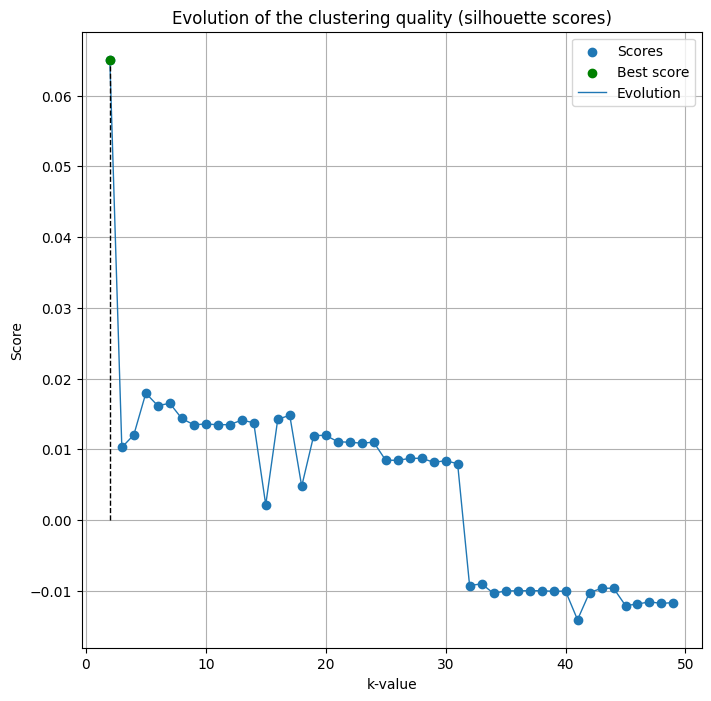

In [8]:
# Perform iterations storing the silhouette score
ks_to_test        = range(2, 50)
clustering_scores =np.zeros(shape=len(ks_to_test), dtype=np.float32)

# Get the input space (by removing the target variable)
X = df_supervised_task1.drop(columns=['Target'], axis=1).to_numpy()

# Get the target variable
y = df_supervised_task1['Target'].to_numpy()

# Perform the k_means algorithm iteratively
for i in tqdm(range(len(ks_to_test))):
    k                   = ks_to_test[i]
    kmeans               = KMeans(n_clusters=k, random_state=42)
    labels               = kmeans.fit_predict(X=X)
    current_score        = silhouette_score(X=X, labels=labels)
    clustering_scores[i] = current_score

# Select the best k
best_index = np.argmax(clustering_scores)
k_best     = ks_to_test[best_index]

# Plot the evolution of the silhouette scores
plt.figure(figsize=(8, 8))
plt.title("Evolution of the clustering quality (silhouette scores)")
plt.scatter(ks_to_test, clustering_scores, label='Scores', zorder=2)
plt.scatter(k_best, clustering_scores[best_index], c='green', label='Best score', zorder=3)
plt.plot(ks_to_test, clustering_scores, label='Evolution', linewidth=1.0)
plt.plot([k_best, k_best], [0.0, clustering_scores[best_index]], c='black', linestyle='--', linewidth=1.0)
plt.xlabel("k-value")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

With all the silhouette scores, the maximum value (with its corresponding $k$) must be chosen.

## Make a descriptive analysis of each cluster

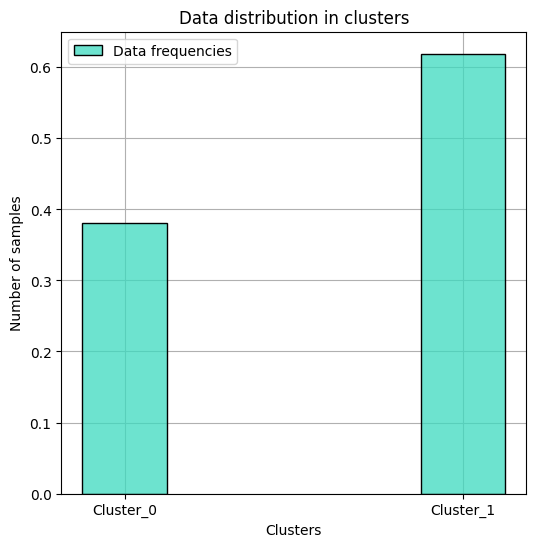

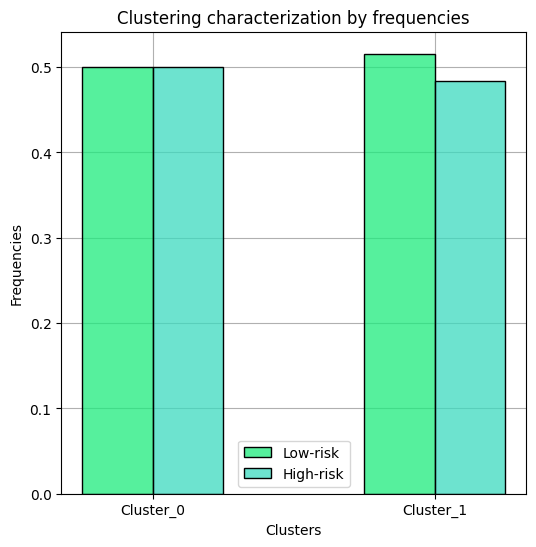

In [9]:
# Compute the optimal clustering
kmeans = KMeans(n_clusters=k_best, random_state=42)
labels = kmeans.fit_predict(X=X)

# Compute absolute frequencies
unique_labels  = np.unique(labels)
n_total        = len(labels)
absolute_freqs = [ len(np.where(labels == label)[0]) / n_total for label in unique_labels]

# Make a bar plot
clusters_arange = np.arange(len(unique_labels))
clusters        = [ f"Cluster_{i}" for i in clusters_arange ]
bar_width      = 0.25
plt.figure(figsize=(6, 6))
plt.title("Data distribution in clusters")
plt.bar(x=clusters_arange, 
        height=absolute_freqs, 
        width=bar_width, 
        label="Data frequencies", 
        zorder=2,
        edgecolor='black',
        color=(0.113, 0.921, 0.4901, 0.75) if i == 0 else (0.235, 0.855, 0.749, 0.75))
plt.xticks(ticks=clusters_arange, labels=clusters)
plt.xlabel("Clusters")
plt.ylabel("Number of samples")
plt.grid(True)
plt.legend()
plt.show()

# Compute frequencies within clusters
clusters_frequencies = {}
for label in unique_labels:
    label_instances             = y[np.where(labels == label)]
    n_cluster                   = len(label_instances)
    clusters_frequencies[label] = [ len(np.where(label_instances == 0)[0]) / n_cluster, len(np.where(label_instances == 1)[0]) / n_cluster ]

# Make a bar plot
classes         = [ 'Low-risk', 'High-risk' ]
clusters_arange = np.arange(len(unique_labels))
clusters        = [ f"Cluster_{i}" for i in clusters_arange ]
bar_width      = 0.25
plt.figure(figsize=(6, 6))
plt.title("Clustering characterization by frequencies")
for i, _class in enumerate(classes):
    height = [ clusters_frequencies[label][i] for label in unique_labels ]
    plt.bar(x=clusters_arange + i * bar_width, 
            height=height, 
            width=bar_width, 
            label=_class, 
            zorder=2,
            edgecolor='black',
            color=(0.113, 0.921, 0.4901, 0.75) if i == 0 else (0.235, 0.855, 0.749, 0.75))
plt.xticks(ticks=clusters_arange + bar_width / len(classes), labels=clusters)
plt.xlabel("Clusters")
plt.ylabel("Frequencies")
plt.grid(True)
plt.legend()
plt.show()

## Trying other number of clusters

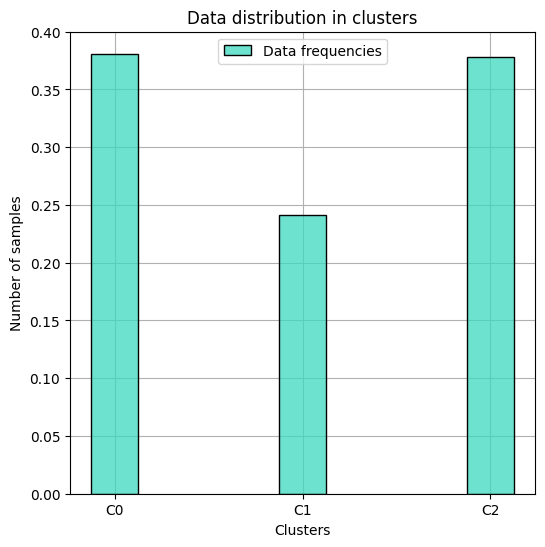

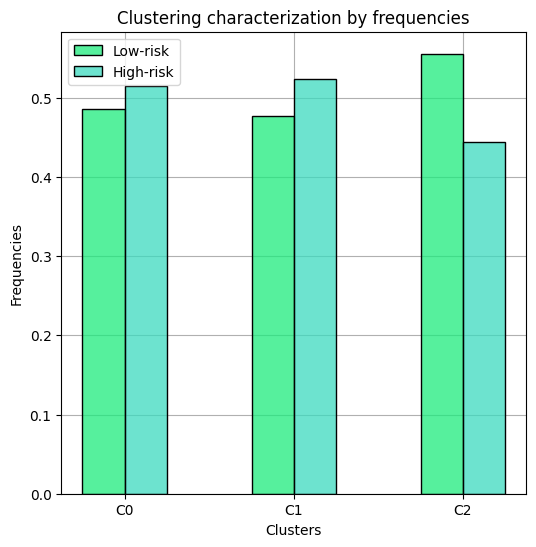

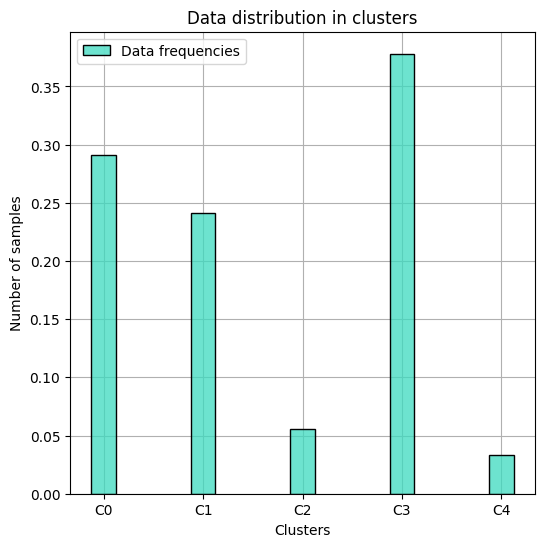

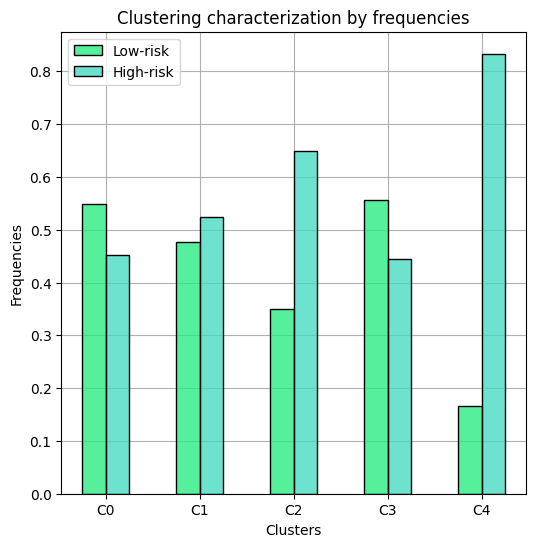

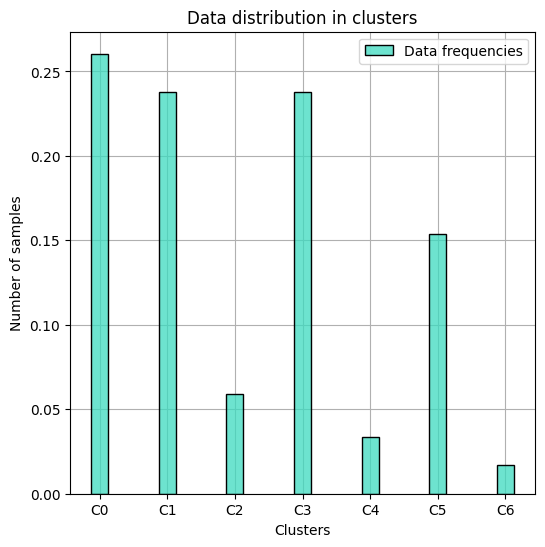

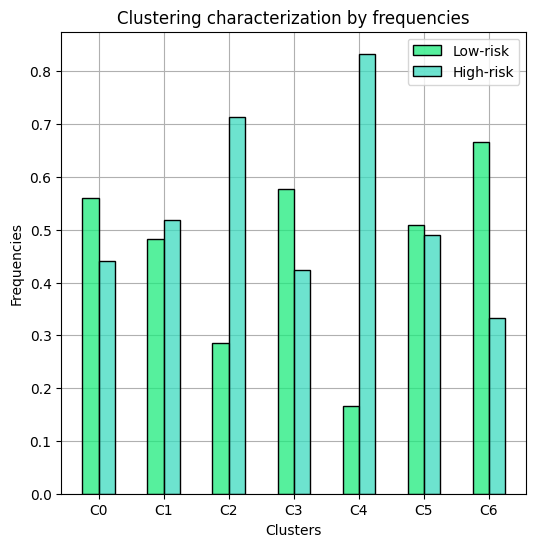

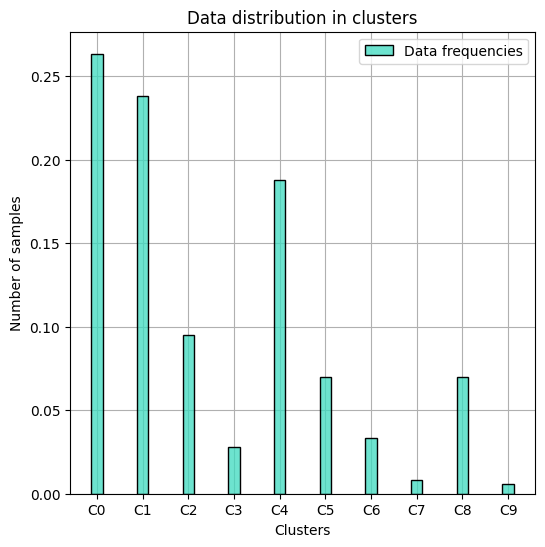

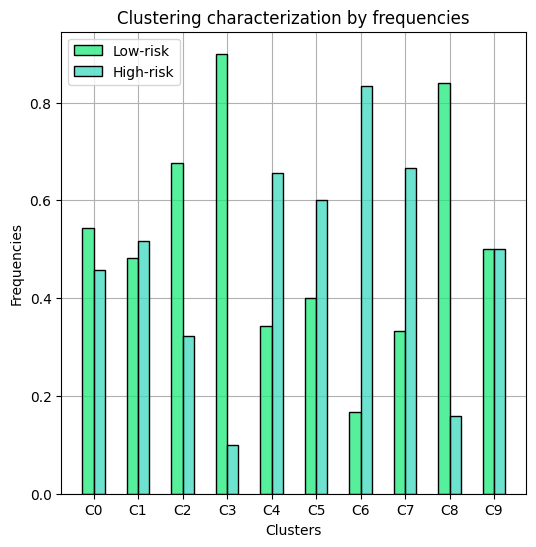

In [10]:
# Select the k's to test
ks = [3, 5, 7, 10]

for k in ks:
    # Compute the optimal clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X=X)

    # Compute absolute frequencies
    unique_labels  = np.unique(labels)
    n_total        = len(labels)
    absolute_freqs = [ len(np.where(labels == label)[0]) / n_total for label in unique_labels]

    # Make a bar plot
    clusters_arange = np.arange(len(unique_labels))
    clusters        = [ f"C{i}" for i in clusters_arange ]
    bar_width      = 0.25
    plt.figure(figsize=(6, 6))
    plt.title("Data distribution in clusters")
    plt.bar(x=clusters_arange, 
            height=absolute_freqs, 
            width=bar_width, 
            label="Data frequencies", 
            zorder=2,
            edgecolor='black',
            color=(0.113, 0.921, 0.4901, 0.75) if i == 0 else (0.235, 0.855, 0.749, 0.75))
    plt.xticks(ticks=clusters_arange, labels=clusters)
    plt.xlabel("Clusters")
    plt.ylabel("Number of samples")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Compute frequencies within clusters
    clusters_frequencies = {}
    for label in unique_labels:
        label_instances             = y[np.where(labels == label)]
        n_cluster                   = len(label_instances)
        clusters_frequencies[label] = [ len(np.where(label_instances == 0)[0]) / n_cluster, len(np.where(label_instances == 1)[0]) / n_cluster ]

    # Make a bar plot
    classes         = [ 'Low-risk', 'High-risk' ]
    clusters_arange = np.arange(len(unique_labels))
    clusters        = [ f"C{i}" for i in clusters_arange ]
    bar_width      = 0.25
    plt.figure(figsize=(6, 6))
    plt.title("Clustering characterization by frequencies")
    for i, _class in enumerate(classes):
        height = [ clusters_frequencies[label][i] for label in unique_labels ]
        plt.bar(x=clusters_arange + i * bar_width, 
                height=height, 
                width=bar_width, 
                label=_class, 
                zorder=2,
                edgecolor='black',
                color=(0.113, 0.921, 0.4901, 0.75) if i == 0 else (0.235, 0.855, 0.749, 0.75))
    plt.xticks(ticks=clusters_arange + bar_width / len(classes), labels=clusters)
    plt.xlabel("Clusters")
    plt.ylabel("Frequencies")
    plt.grid(True)
    plt.legend()
    plt.show()

## KL-Divergence testing

The **Kullback-Leibler (KL) divergence** is a measure of how one probability distribution differs from a second, reference probability distribution. It is widely used in statistics, machine learning, and information theory to quantify the distance between two distributions.

KL divergence is **not symmetric**, meaning that $D_{\text{KL}}(P \parallel Q) \neq D_{\text{KL}}(Q \parallel P)$. So it is very important to note that KL divergence **is not a distance, but rather a similarity measure**.

#### Continuous Case

For continuous probability density functions $p(x)$ and $q(x)$, the KL divergence is defined as:

\begin{equation}
    D_{\text{KL}}(p \parallel q) = \int_{-\infty}^{\infty} p(x) \log \left( \frac{p(x)}{q(x)} \right) dx
\end{equation}

In both cases, the KL divergence is always non-negative and equals zero if and only if $P = Q$ (or $p(x) = q(x)$ almost everywhere in the continuous case).

#### Discrete Case

For two discrete probability distributions $P$ and $Q$ defined over the same set $\mathcal{X}$, the KL divergence from $Q$ to $P$ is given by:

\begin{equation}
D_{\text{KL}}(P \parallel Q) = \sum_{x \in \mathcal{X}} P(x) \log \left( \frac{P(x)}{Q(x)} \right)
\end{equation}


In [11]:
# Get the probability distribution of the target variable
y_total = len(y)
y_probs = np.array([ len(np.where(y == 0)[0]) / y_total, len(np.where(y == 1)[0]) / y_total ], dtype=np.float32)
print(f"Target variable probability distribution: {y_probs}")

# Compare it with a trivial 50-50 distribution
y_trivial = np.array([ 0.5, 0.5 ], dtype=np.float32)
KL1 = np.sum(rel_entr(y_probs, y_trivial))
KL2 = np.sum(rel_entr(y_trivial, y_probs))
print(f"Kullback-Leibler divergence between y_probs and y_trivial: {KL1}")
print(f"Kullback-Leibler divergence between y_trivial and y_probs: {KL2}")
print(f"Average Kullback-Leibler divergence (both directions): {(KL1 + KL2) * 0.5}")

Target variable probability distribution: [0.50980395 0.49019608]
Kullback-Leibler divergence between y_probs and y_trivial: 0.00019227620214223862
Kullback-Leibler divergence between y_trivial and y_probs: 0.00019224174320697784
Average Kullback-Leibler divergence (both directions): 0.00019225897267460823


The KL average value tends to zero, meaning both distributions are very similar.

## Conclusion

Having analyzed the target variable from the perspective of entropy and KL divergence, along with the approach of clustering similar instances to observe labeling patterns, we can conclude—with a high degree of certainty and a solid statistical foundation—that the **data in Task 1 has been labeled randomly with maybe some sort of bias to allow 60-40 classification results for certain models, lacking any discernible pattern or phenomenon that could be learned by Machine Learning models**. This justifies the results obtained using any of the approaches applied to this task across the remaining notebooks.